## Import Libraries

In [227]:
from deepface import DeepFace
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

import os
from pathlib import Path
from IPython.display import display
import cv2

from sklearn import metrics

### Paths

In [171]:
image_pth = '/home/dave/discovery_projects/driving_test_impersonation/lfw_images/lfw-deepfunneled/lfw-deepfunneled/'

### Load required Data

In [63]:
im_features1 = pd.read_csv("/mnt/c/Users/Davidj/OneDrive - Driver and Vehicle Standards Agency/Documents/Projects/Discovery/Driving test facial Recognition/Main Discovery/deepface_test/face_classifications_csvs/lfw_class1.csv")
im_features2 = pd.read_csv("/mnt/c/Users/Davidj/OneDrive - Driver and Vehicle Standards Agency/Documents/Projects/Discovery/Driving test facial Recognition/Main Discovery/deepface_test/face_classifications_csvs/lfw_class2.csv")
im_features3 = pd.read_csv("/mnt/c/Users/Davidj/OneDrive - Driver and Vehicle Standards Agency/Documents/Projects/Discovery/Driving test facial Recognition/Main Discovery/deepface_test/face_classifications_csvs/lfw_class3.csv")

im_features = pd.concat([im_features1, im_features2, im_features3], axis=0)

im_features.rename(columns = {'Name' : 'Image'}, inplace=True)

im_features['Name'] = im_features['Image'].str.replace(r'_\d{4}\.jpg$', '', regex=True)

# Remove nan
im_features = im_features[~im_features['Race'].isna()]

im_features.head()

,Unnamed: 0,Image,Age,Gender,Race,Emotion,face confidence,Name
0,0,Antonio_Trillanes_0002.jpg,28,Man,black,surprise,0.91,Antonio_Trillanes
1,1,Antonio_Trillanes_0001.jpg,32,Man,asian,fear,0.92,Antonio_Trillanes
2,2,Antonio_Trillanes_0003.jpg,22,Man,asian,sad,0.93,Antonio_Trillanes
3,3,Priscilla_Owen_0002.jpg,39,Woman,white,happy,0.91,Priscilla_Owen
4,4,Priscilla_Owen_0001.jpg,35,Woman,white,neutral,0.88,Priscilla_Owen


In [107]:
im_features1.shape, im_features2.shape, im_features3.shape, im_features.shape

im_features = im_features[im_features["Name"].duplicated(keep=False)]

min(im_features.groupby("Name")["Name"].count())

2

In [108]:
im_features['Race'].unique()

sum(im_features['Race'].isna())

im_features['Race'].unique()

array(['black', 'asian', 'white', 'middle eastern', 'latino hispanic',
       'indian'], dtype=object)

### Get the numbers of different ethnicities

In [109]:
im_features_unique = im_features.groupby('Name')['Race'].apply(lambda x: '|'.join(sorted(x.unique()))).reset_index()

sum(im_features_unique['Race'] == 'indian')

2

### Create matched test set

In [110]:
im_features

,Unnamed: 0,Image,Age,Gender,Race,Emotion,face confidence,Name
0,0,Antonio_Trillanes_0002.jpg,28,Man,black,surprise,0.91,Antonio_Trillanes
1,1,Antonio_Trillanes_0001.jpg,32,Man,asian,fear,0.92,Antonio_Trillanes
2,2,Antonio_Trillanes_0003.jpg,22,Man,asian,sad,0.93,Antonio_Trillanes
3,3,Priscilla_Owen_0002.jpg,39,Woman,white,happy,0.91,Priscilla_Owen
4,4,Priscilla_Owen_0001.jpg,35,Woman,white,neutral,0.88,Priscilla_Owen
...,...,...,...,...,...,...,...,...
2809,2809,Paul_Bremer_0004.jpg,38,Man,white,neutral,0.89,Paul_Bremer
2810,2810,Paul_Bremer_0003.jpg,34,Man,white,neutral,0.90,Paul_Bremer
2811,2811,Paul_Bremer_0018.jpg,37,Man,white,fear,0.88,Paul_Bremer
2812,2812,Morgan_Freeman_0001.jpg,37,Man,black,neutral,0.94,Morgan_Freeman


In [349]:
# White images
im_features_white = im_features[im_features["Race"] == "white"]

im_features_white["Race"].unique()

# Black images
im_features_black = im_features[im_features["Race"] == "black"]

im_features_black.shape, im_features_white.shape

((440, 8), (4809, 8))

In [161]:
im_features_matched_white = im_features_unique[im_features_unique["Race"] == "white" ]

im_features_matched_white["Path1"] = [im_features[im_features["Name"] == x]["Image"].iloc[0] for x in im_features_matched_white["Name"]]
im_features_matched_white["Path2"] = [im_features[im_features["Name"] == x]["Image"].iloc[1] for x in im_features_matched_white["Name"]]

im_features_matched_white

,Name,Race,Path1,Path2
0,Aaron_Peirsol,white,Aaron_Peirsol_0004.jpg,Aaron_Peirsol_0002.jpg
18,Aitor_Gonzalez,white,Aitor_Gonzalez_0001.jpg,Aitor_Gonzalez_0002.jpg
21,Al_Pacino,white,Al_Pacino_0002.jpg,Al_Pacino_0001.jpg
23,Alan_Ball,white,Alan_Ball_0001.jpg,Alan_Ball_0002.jpg
25,Alastair_Campbell,white,Alastair_Campbell_0003.jpg,Alastair_Campbell_0005.jpg
...,...,...,...,...
1450,Xavier_Malisse,white,Xavier_Malisse_0003.jpg,Xavier_Malisse_0001.jpg
1454,Yevgeny_Kafelnikov,white,Yevgeny_Kafelnikov_0002.jpg,Yevgeny_Kafelnikov_0001.jpg
1457,Yossi_Beilin,white,Yossi_Beilin_0001.jpg,Yossi_Beilin_0002.jpg
1467,Zico,white,Zico_0003.jpg,Zico_0001.jpg


### Create unmatched test set

In [206]:
imN = 500

im_features_unmatched_white_sel = im_features_white.iloc[np.random.randint(low=0, high=len(im_features_white), size=imN) ]

im_features_unmatched_white_sel2 = im_features_white.iloc[np.random.randint(low=0, high=len(im_features_white), size=imN)]

im_features_unmatched_white = pd.DataFrame({"Name1" : list(im_features_unmatched_white_sel["Name"]),
                                            "Name2": list(im_features_unmatched_white_sel2["Name"]),
                                             "Image1" : list(im_features_unmatched_white_sel["Image"]),
                                             "Image2" : list(im_features_unmatched_white_sel2["Image"])
                                             })

im_features_unmatched_white = im_features_unmatched_white[~(im_features_unmatched_white["Name1"] == im_features_unmatched_white["Name2"])]

im_features_unmatched_white.head()

,Name1,Name2,Image1,Image2
0,John_Snow,Celine_Dion,John_Snow_0001.jpg,Celine_Dion_0002.jpg
1,Paul_Gascoigne,Jose_Manuel_Durao_Barroso,Paul_Gascoigne_0002.jpg,Jose_Manuel_Durao_Barroso_0002.jpg
2,Alexander_Losyukov,John_Rowland,Alexander_Losyukov_0002.jpg,John_Rowland_0002.jpg
3,Tony_Blair,Jennifer_Reilly,Tony_Blair_0114.jpg,Jennifer_Reilly_0001.jpg
4,Jennifer_Aniston,George_W_Bush,Jennifer_Aniston_0005.jpg,George_W_Bush_0187.jpg


### Run a deepface on matched and unmatched

In [207]:
im_features_matched_white_test = pd.DataFrame({"Name1":list(im_features_matched_white["Name"]),
                                               "Name2":list(im_features_matched_white["Name"]),
                                               "Image1":list(im_features_matched_white["Path1"]),
                                               "Image2":list(im_features_matched_white["Path2"])
                                               } )

im_features_white_test = pd.concat([im_features_matched_white_test, im_features_unmatched_white], axis = 0).reset_index()

im_features_white_test

,index,Name1,Name2,Image1,Image2
0,0,Aaron_Peirsol,Aaron_Peirsol,Aaron_Peirsol_0004.jpg,Aaron_Peirsol_0002.jpg
1,1,Aitor_Gonzalez,Aitor_Gonzalez,Aitor_Gonzalez_0001.jpg,Aitor_Gonzalez_0002.jpg
2,2,Al_Pacino,Al_Pacino,Al_Pacino_0002.jpg,Al_Pacino_0001.jpg
3,3,Alan_Ball,Alan_Ball,Alan_Ball_0001.jpg,Alan_Ball_0002.jpg
4,4,Alastair_Campbell,Alastair_Campbell,Alastair_Campbell_0003.jpg,Alastair_Campbell_0005.jpg
...,...,...,...,...,...
1078,495,Jeremy_Greenstock,Amelie_Mauresmo,Jeremy_Greenstock_0011.jpg,Amelie_Mauresmo_0008.jpg
1079,496,Laura_Bush,Justin_Timberlake,Laura_Bush_0008.jpg,Justin_Timberlake_0003.jpg
1080,497,Emma_Watson,Colin_Powell,Emma_Watson_0002.jpg,Colin_Powell_0049.jpg
1081,498,Asa_Hutchinson,Paul_Bremer,Asa_Hutchinson_0001.jpg,Paul_Bremer_0009.jpg


In [350]:
## VGG-face
# white
# match_white_test = []

# for dx in range(0, len(im_features_white_test)):
    
#     if dx%10 == 0:
#         print(f'Image number: {dx}')
       
#     result = DeepFace.verify(
#         img1_path = f'{image_pth}{im_features_white_test["Name1"][dx]}/{im_features_white_test["Image1"][dx]}',
#         img2_path = f'{image_pth}{im_features_white_test["Name2"][dx]}/{im_features_white_test["Image2"][dx]}'
#     )
    
#     match_white_test.append(result)

## 

match_white_test_facenet512 = []

for dx in range(0, len(im_features_white_test)):
    
    if dx%10 == 0:
        print(f'Image number: {dx}')
       
    result = DeepFace.verify(
        img1_path = f'{image_pth}{im_features_white_test["Name1"][dx]}/{im_features_white_test["Image1"][dx]}',
        img2_path = f'{image_pth}{im_features_white_test["Name2"][dx]}/{im_features_white_test["Image2"][dx]}',
        model_name="Facenet512"
    )
    
    match_white_test_facenet512.append(result)


#result

Image number: 680
Image number: 690
Image number: 700
Image number: 710
Image number: 720
Image number: 730
Image number: 740
Image number: 750
Image number: 760
Image number: 770
Image number: 780
Image number: 790
Image number: 800
Image number: 810
Image number: 820
Image number: 830
Image number: 840
Image number: 850
Image number: 860
Image number: 870
Image number: 880
Image number: 890
Image number: 900
Image number: 910
Image number: 920
Image number: 930
Image number: 940
Image number: 950
Image number: 960
Image number: 970
Image number: 980
Image number: 990
Image number: 1000
Image number: 1010
Image number: 1020
Image number: 1030
Image number: 1040
Image number: 1050
Image number: 1060
Image number: 1070
Image number: 1080


In [355]:
## VGG-face

# match_white_test_dist = [x["distance"] for x in match_white_test]

# match_white_test_dist

# im_features_white_test["dist"] = match_white_test_dist
# im_features_white_test["Match"] = ((im_features_white_test["Name1"] == im_features_white_test["Name2"]))

# im_features_white_test["Match"] = im_features_white_test["Match"].replace({True: 'Match', False: 'No Match'})

# im_features_white_test["Confidence"] = 1- im_features_white_test["dist"]

# im_features_white_test

## Facenet 512
match_white_test_dist_facenet512 = [x["distance"] for x in match_white_test_facenet512]

im_features_white_test["dist_facenet512"] = match_white_test_dist_facenet512

im_features_white_test["Confidence_facenet512"] = 1- im_features_white_test["dist_facenet512"]

im_features_white_test["dist_facenet512"].max()

1.3362745611292572

### Plot the ROC curve

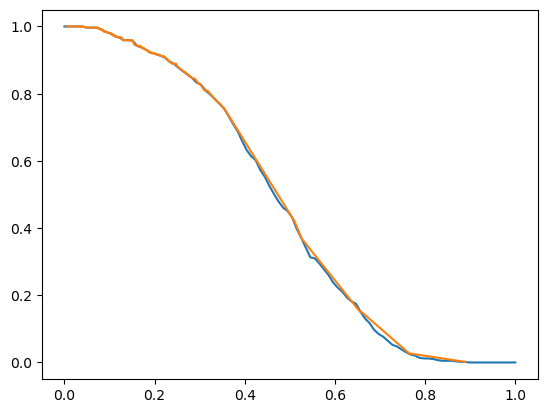

In [326]:
## This is just checking I understand how TPR works in sci-kit learn
def tpr_calc(df, threshold, confidence = "Confidence", truth = "Match",  pos_label = "Match"):
    
    tp = len(df[(df[confidence] >= threshold) & (df[truth] == pos_label)])
    fn = len(df[(df[confidence] < threshold) & (df[truth] == pos_label)])
    
    tpr = float(tp)/float(tp + fn)
    
    return(tpr)


tpr_test = tpr_calc(im_features_white_test, 0.5)

threshold_array = np.linspace(0, 1, 100)

tpr_test = [tpr_calc(im_features_white_test, x) for x in threshold_array]

plt.plot(threshold_array, tpr_test)
plt.plot(thresholds, tpr)

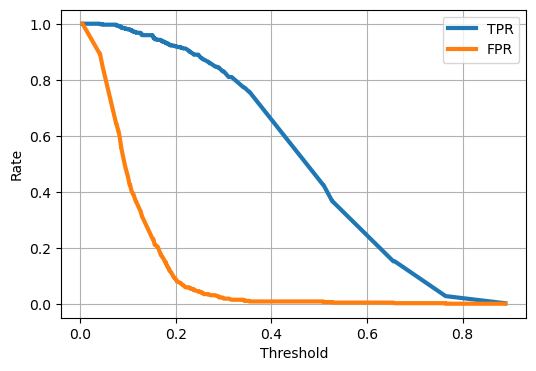

In [297]:
fpr, tpr, thresholds = metrics.roc_curve(im_features_white_test['Match'], im_features_white_test['Confidence'], pos_label='Match')

tnr = 1 - fpr
fnr = 1 - tpr

# axes = plt.subplot()
# axes.plot(thresholds, tpr)
# axes.plot(thresholds, fpr)
# axes.plot(thresholds, tnr)
# axes.plot(thresholds, fnr)

# axes.set_xlabel('Threshold')
# axes.set_ylabel('True Positive Rate')
# axes.grid()
# plt.legend(["TPR", "FPR", "TNR", "FNR"])

rocfig,rocaxes = plt.subplots(figsize =(6, 4))
rocaxes.plot(thresholds, tpr, linewidth = 3)
rocaxes.plot(thresholds, fpr, linewidth = 3)
rocaxes.set_xlabel('Threshold')
rocaxes.set_ylabel('Rate')
rocaxes.grid()
rocaxes.legend(["TPR", "FPR"])

# rocaxes2 = plt.subplot()
# rocaxes2.plot(fnr, tnr)
# rocaxes2.set_xlabel('FNR')
# rocaxes2.set_ylabel('TNR')
# rocaxes2.grid()


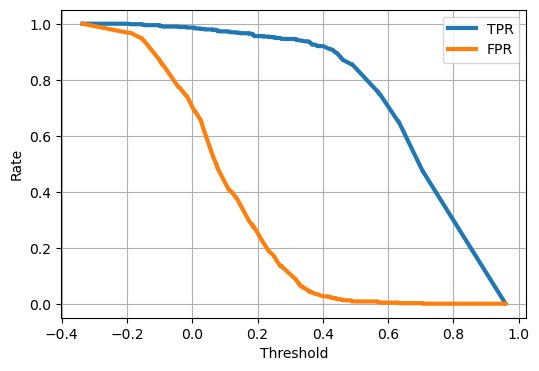

In [356]:
fpr, tpr, thresholds = metrics.roc_curve(im_features_white_test['Match'], im_features_white_test['Confidence_facenet512'], pos_label='Match')


rocfig,rocaxes = plt.subplots(figsize =(6, 4))
rocaxes.plot(thresholds, tpr, linewidth = 3)
rocaxes.plot(thresholds, fpr, linewidth = 3)
rocaxes.set_xlabel('Threshold')
rocaxes.set_ylabel('Rate')
rocaxes.grid()
rocaxes.legend(["TPR", "FPR"])


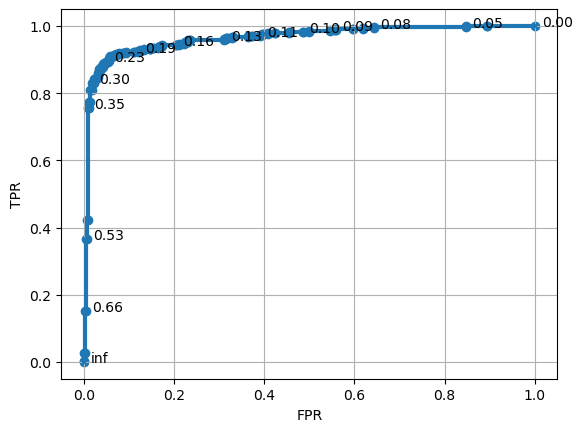

In [348]:
rocaxes2 = plt.subplot()
rocaxes2.plot(fpr, tpr, linewidth = 3)
rocaxes2.scatter(fpr, tpr, linewidth = 1)
rocaxes2.set_xlabel('FPR')
rocaxes2.set_ylabel('TPR')
rocaxes2.grid()

fpr_ref = fpr[0]
tpr_ref = tpr[0]

rocaxes2.annotate(f'{thresholds[0]:.2f}', (fpr[0], tpr[0]), textcoords="offset points", xytext=(5,0), ha='left')
for i, threshold in enumerate(thresholds):
    
    if (tpr_ref  - tpr[i])**2 + (fpr_ref  - fpr[i])**2 > 0.005:
    
        rocaxes2.annotate(f'{threshold:.2f}', (fpr[i], tpr[i]), textcoords="offset points", xytext=(5,0), ha='left')
        fpr_ref = fpr[i]
        tpr_ref = tpr[i]

In [343]:
fpr_ref, tpr_ref, i, fpr[i], (tpr_ref**2 + fpr_ref**2) - (fpr[i]**2 + tpr[i]**2)

(0.0, 0.0, 139, 1.0, -2.0)

In [275]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Sample true labels and predicted probabilities (from a classifier)
y_true = im_features_white_test["Match"]
y_prob = im_features_white_test["Confidence"]

# Define a range of thresholds
thresholds = np.arange(0.0, 1.1, 0.05)

# Initialize lists to store TNR and FNR values for each threshold
tnr_list = []
fnr_list = []

# Iterate over the thresholds
for thresh in thresholds:
    # Apply threshold to get binary predictions
    y_pred = (y_prob >= thresh).astype(int)
    
    # Compute confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # TPR
    tpr = tp/(tp + fn)
    
    # FPR
    fpr = fp/(fp + tn)
    
    # Calculate True Negative Rate (TNR)
    tnr = tn / (tn + fp)
    
    # Calculate False Negative Rate (FNR)
    fnr = fn / (fn + tp)
    
    # Append the rates to the lists
    tnr_list.append(tnr)
    fnr_list.append(fnr)

# Print the results
for thresh, tnr, fnr in zip(thresholds, tnr_list, fnr_list):
    print(f'Threshold: {thresh:.1f}, TNR: {tnr:.2f}, FNR: {fnr:.2f}')


Threshold: 0.0, TNR: 0.00, FNR: 0.00
Threshold: 0.1, TNR: 0.17, FNR: 0.00
Threshold: 0.1, TNR: 0.55, FNR: 0.02
Threshold: 0.2, TNR: 0.76, FNR: 0.04
Threshold: 0.2, TNR: 0.91, FNR: 0.08
Threshold: 0.2, TNR: 0.96, FNR: 0.12
Threshold: 0.3, TNR: 0.98, FNR: 0.17
Threshold: 0.4, TNR: 0.99, FNR: 0.24
Threshold: 0.4, TNR: 0.99, FNR: 0.35
Threshold: 0.5, TNR: 0.99, FNR: 0.46
Threshold: 0.5, TNR: 0.99, FNR: 0.56
Threshold: 0.6, TNR: 1.00, FNR: 0.69
Threshold: 0.6, TNR: 1.00, FNR: 0.77
Threshold: 0.7, TNR: 1.00, FNR: 0.83
Threshold: 0.7, TNR: 1.00, FNR: 0.92
Threshold: 0.8, TNR: 1.00, FNR: 0.96
Threshold: 0.8, TNR: 1.00, FNR: 0.99
Threshold: 0.9, TNR: 1.00, FNR: 0.99
Threshold: 0.9, TNR: 1.00, FNR: 1.00
Threshold: 1.0, TNR: 1.00, FNR: 1.00
Threshold: 1.0, TNR: 1.00, FNR: 1.00
Threshold: 1.1, TNR: 1.00, FNR: 1.00


(array([0.        , 0.        , 0.33333333, 0.33333333, 1.        ]),
 array([0. , 0.5, 0.5, 1. , 1. ]),
 array([ inf, 0.8 , 0.4 , 0.35, 0.1 ]))